In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../../slayerPytorch/src")

In [31]:
import slayerSNN as snn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw, accelerated_dtw
from numpy.linalg import norm
from joblib import Parallel, delayed
import torch
import copy
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

np.random.seed(1)
torch.manual_seed(1)

In [32]:
X = torch.load('../BioTac_Icub_data/ICUB_all.pt').numpy()
Y = np.load('../BioTac_Icub_data/ICUB_all_labels.npy')

In [33]:
X.shape, Y.shape

((1000, 6, 10, 75), (1000,))

In [34]:
def get_ohe(_Y):
    target_class = np.zeros([_Y.shape[0], 20])
    for i in range(target_class.shape[0]):
        target_class[i, int(_Y[i])] = 1
    return target_class

In [35]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1, X.shape[-1])
# Y = Y.reshape(Y.shape[0], Y.shape[1], 1, 1, Y.shape[-1])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, stratify=Y)

In [37]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

target_class_train = torch.FloatTensor(get_ohe(y_train).reshape(-1, 20, 1, 1, 1))
    
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
target_class_test= torch.FloatTensor(get_ohe(y_test).reshape(-1, 20, 1, 1, 1))


X_train.shape, y_train.shape, target_class_train.shape

(torch.Size([700, 6, 10, 1, 75]),
 torch.Size([700]),
 torch.Size([700, 20, 1, 1, 1]))

In [38]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 5, # 10
        "tauSr": 10.0,
        "tauRef": 1.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 75, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 75,
            },
            "tgtSpikeCount": {True: 55, False: 10},
        }
    },
}


In [39]:
train_dataset = torch.utils.data.TensorDataset(X_train, target_class_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=8)

test_dataset = torch.utils.data.TensorDataset(X_test, target_class_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True,batch_size=8)

In [40]:
class SlayerMLP(torch.nn.Module):
    def __init__(self, params, input_size, hidden_size, output_size):
        super(SlayerMLP, self).__init__()
        self.output_size = output_size
        self.slayer = snn.layer(params["neuron"], params["simulation"])
        self.fc1 = self.slayer.dense((10,6,1), hidden_size)
        self.fc2 = self.slayer.dense(hidden_size, output_size)

    def get_spike(self, spike_input):
        spike_1 = self.slayer.spike(spike_input)
        return spike_1
    def forward(self, spike_input):
        spike_1 = self.slayer.spike(self.slayer.psp(self.fc1(spike_input)))
        spike_output = self.slayer.spike(self.slayer.psp(self.fc2(spike_1)))
        return spike_output

In [41]:
# class SlayerMLP(torch.nn.Module):
#     def __init__(self, params, input_size, hidden_size, output_size):
#         super(SlayerMLP, self).__init__()
#         self.output_size = output_size
#         self.slayer = snn.layer(params["neuron"], params["simulation"])
# #         self.fc1 = self.slayer.dense((1,10,6), hidden_size)
#         self.fc = self.slayer.dense((9,5,3), output_size)
#         self.conv1 = self.slayer.conv(1, 3, 2)

#     def forward(self, spike_input):
#         spike1 = self.slayer.spike(self.conv1(spike_input))
# #         print(spike1.shape)
#         spike3 = self.slayer.spike(self.fc(self.slayer.psp(spike1)))
# #         print(spike3.shape)
# #         spike_1 = self.slayer.spike(self.fc1(spike_input))
# #         spike_output = self.slayer.spike(self.slayer.psp(self.fc2(spike_1)))
#         return spike3

In [42]:
device = torch.device("cuda:1")
net = SlayerMLP(params, 19, 128, 20).to(device)

In [43]:
error = snn.loss(params).to(device)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.5)

In [44]:
148/len(train_dataset)

0.21142857142857144

In [45]:
train_losses=[]
train_accs = []
test_losses = []
test_accs = []
for epoch in range(301):
    net.train()
    correct = 0
    num_samples = 0
    loss_train = 0
    for i, (tact, target, label) in enumerate(train_loader):
        
        tact = tact.to(device)
        tact = tact.permute(0, 3, 1, 2, 4)
#         print(tact.shape)

        tact = net.get_spike(tact)
        target = target.to(device)
        output = net.forward(tact)
        correct += torch.sum(snn.predict.getClass(output) == label).data.item()
        num_samples += len(label)
        loss = error.numSpikes(output, target)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    if epoch%10 == 0:
        print('Epoch: ', epoch, ' --------------------------')
        print('Train loss:', loss_train/len(train_dataset))
        print('Train accuracy:', correct/len(train_dataset))
    train_accs.append(correct/len(train_dataset))
    train_losses.append(loss_train/len(train_dataset))
        
    net.eval()
    correct = 0
    num_samples = 0
    loss_test = 0
    with torch.no_grad():
        for i, (tact, target, label) in enumerate(test_loader):

            tact = tact.to(device)
            tact = tact.permute(0, 3, 1, 2, 4)
            target = target.to(device)
            tact = net.get_spike(tact)
            output = net.forward(tact)
            correct += torch.sum(snn.predict.getClass(output) == label).data.item()
            num_samples += len(label)
            loss = error.numSpikes(output, target)
            loss_test += loss.item()
            
    if epoch%10 == 0:
        print('Test loss:', loss_test/len(test_dataset))
        print('Test accuracy:', correct/len(test_dataset))
    test_accs.append(correct/len(test_dataset))
    test_losses.append(loss_test/len(test_dataset))

Epoch:  0  --------------------------
Train loss: 31.800087280273438
Train accuracy: 0.1
Test loss: 28.626090342203778
Test accuracy: 0.16333333333333333
Epoch:  10  --------------------------
Train loss: 14.066343329293387
Train accuracy: 0.6657142857142857
Test loss: 15.304422454833984
Test accuracy: 0.61
Epoch:  20  --------------------------
Train loss: 10.63774321419852
Train accuracy: 0.7685714285714286
Test loss: 12.33444475809733
Test accuracy: 0.71
Epoch:  30  --------------------------
Train loss: 8.903124068123955
Train accuracy: 0.82
Test loss: 10.890511309305827
Test accuracy: 0.7433333333333333
Epoch:  40  --------------------------
Train loss: 7.918981241498675
Train accuracy: 0.8485714285714285
Test loss: 9.97460033416748
Test accuracy: 0.75
Epoch:  50  --------------------------
Train loss: 7.1094097246442525
Train accuracy: 0.8528571428571429
Test loss: 9.45706693649292
Test accuracy: 0.77
Epoch:  60  --------------------------
Train loss: 6.465152536119733
Train accu

KeyboardInterrupt: 

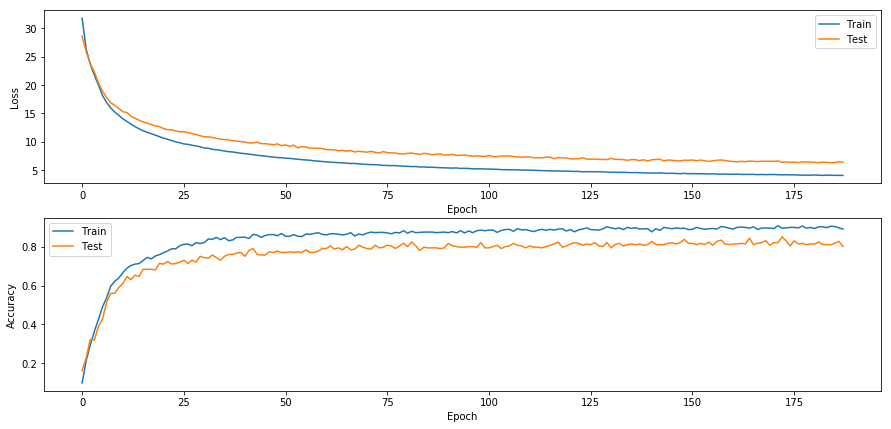

In [46]:
fig, ax = plt.subplots(2, figsize=(15,7))

ax[0].plot(train_losses)
ax[0].plot(test_losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Test'])

ax[1].plot(train_accs)
ax[1].plot(test_accs)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Train', 'Test'])

plt.show()

In [47]:
np.max(test_accs)

0.85

In [48]:
np.max(train_accs)

0.9071428571428571